In [49]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

The dataset can be downloaded from [Kaggle: Food Delivery Time Prediction](https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-predictio)

In [50]:
df = pd.read_csv('../data/Food_Delivery_Times.csv')

# Clean Data and Transform Data

In [51]:
df

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...,...
995,107,8.50,Clear,High,Evening,Car,13,3.0,54
996,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


In [52]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                1000 non-null   int64  
 1   distance_km             1000 non-null   float64
 2   weather                 970 non-null    object 
 3   traffic_level           970 non-null    object 
 4   time_of_day             970 non-null    object 
 5   vehicle_type            1000 non-null   object 
 6   preparation_time_min    1000 non-null   int64  
 7   courier_experience_yrs  970 non-null    float64
 8   delivery_time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [54]:
# order_id is useless
df = df.drop(columns=['order_id'])

In [55]:
categorical_cols = ['weather','traffic_level','time_of_day','vehicle_type']
numeric_cols = ['distance_km','preparation_time_min','courier_experience_yrs','delivery_time_min']

In [56]:
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.lower().str.replace(' ', '_'))

# EDA
## Range of values

In [57]:
df.describe()

,distance_km,preparation_time_min,courier_experience_yrs,delivery_time_min
count,1000.000000,1000.000000,970.000000,1000.000000
mean,10.059970,16.982000,4.579381,56.732000
std,5.696656,7.204553,2.914394,22.070915
min,0.590000,5.000000,0.000000,8.000000
25%,5.105000,11.000000,2.000000,41.000000
50%,10.190000,17.000000,5.000000,55.500000
75%,15.017500,23.000000,7.000000,71.000000
max,19.990000,29.000000,9.000000,153.000000


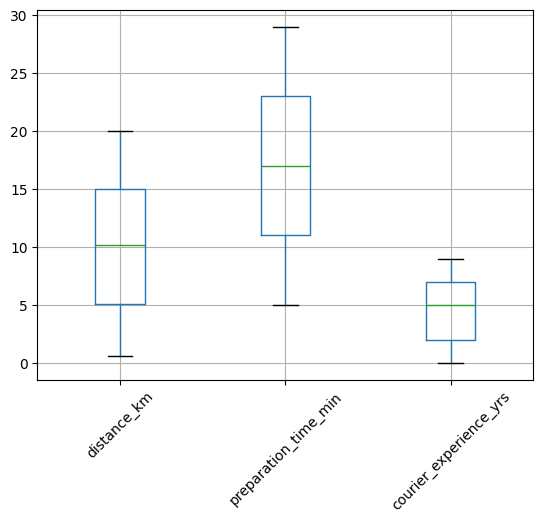

In [58]:
df.boxplot(column=['distance_km','preparation_time_min','courier_experience_yrs'])
plt.xticks(rotation=45)
plt.show()

## Check missing value

In [59]:
df.isnull().sum()

distance_km                0
weather                   30
traffic_level             30
time_of_day               30
vehicle_type               0
preparation_time_min       0
courier_experience_yrs    30
delivery_time_min          0
dtype: int64

In [60]:
# I choose to drop missing data for simplicity
df = df.dropna()

In [61]:
df

,distance_km,weather,traffic_level,time_of_day,vehicle_type,preparation_time_min,courier_experience_yrs,delivery_time_min
0,7.93,windy,low,afternoon,scooter,12,1.0,43
1,16.42,clear,medium,evening,bike,20,2.0,84
2,9.52,foggy,low,night,scooter,28,1.0,59
3,7.44,rainy,medium,afternoon,scooter,5,1.0,37
4,19.03,clear,low,morning,bike,16,5.0,68
...,...,...,...,...,...,...,...,...
995,8.50,clear,high,evening,car,13,3.0,54
996,16.28,rainy,low,morning,scooter,8,9.0,71
997,15.62,snowy,high,evening,scooter,26,2.0,81
998,14.17,clear,low,afternoon,bike,8,0.0,55


## Analysis of target Variable `delivery_time_min`

### Bar plot to visualize target variable distribution

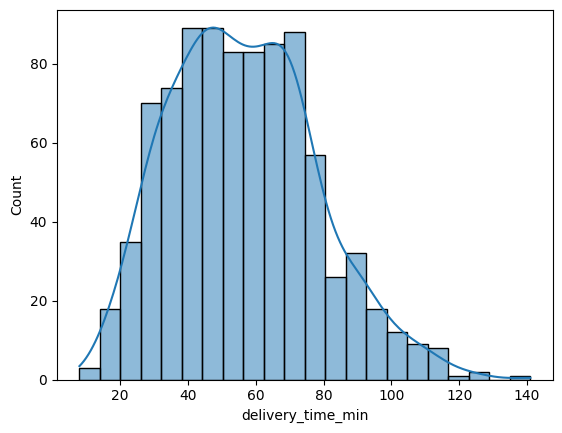

In [62]:
sns.histplot(df['delivery_time_min'], kde=True)
plt.show()

### log-transform

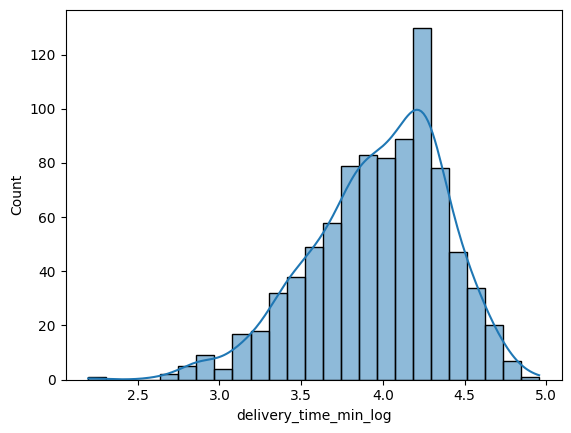

In [63]:
df['delivery_time_min_log'] = np.log1p(df['delivery_time_min'])
sns.histplot(df['delivery_time_min_log'], kde=True)
plt.show()

However, the transformed distribution still appeared irregular likely due to the inherent characteristics of delivery-time data, which often follow a mixture distribution and contain natural outliers.

Since the main models used in this project (e.g., XGBoost, Random Forest) do not require the target variable to be normally distributed and already handle skewed data effectively, the final decision was to avoid using the log-transformed target and proceed with the original scale.

## Feature important

### Correlation

distance_km               0.783226
preparation_time_min      0.296529
courier_experience_yrs    0.076787
Name: delivery_time_min, dtype: float64


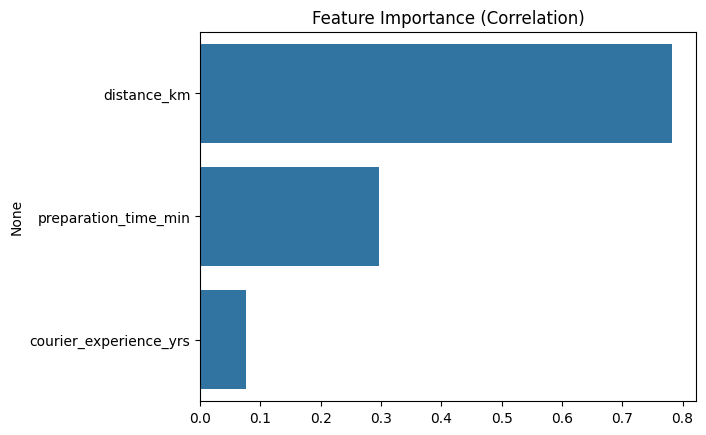

In [64]:
numeric_cols = ['distance_km','preparation_time_min','courier_experience_yrs']
target = 'delivery_time_min'

corr = df[numeric_cols + [target]].corr()[target].drop(target)
corr = corr.abs().sort_values(ascending=False)

print(corr)

sns.barplot(x=corr.values, y=corr.index)
plt.title("Feature Importance (Correlation)")
plt.show()

# Split data

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [67]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y Final ==================================================================
y_train = df_train['delivery_time_min'].values
y_val = df_val['delivery_time_min'].values
y_test = df_test['delivery_time_min'].values
# ==========================================================================

del df_train['delivery_time_min']
del df_val['delivery_time_min']
del df_test['delivery_time_min']

In [68]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_cols = ['weather','traffic_level','time_of_day','vehicle_type']

encoder.fit(df_train[categorical_cols])

X_train_cat = encoder.transform(df_train[categorical_cols])
X_val_cat = encoder.transform(df_val[categorical_cols])
X_test_cat = encoder.transform(df_test[categorical_cols])

numeric_cols = [col for col in df_train.columns if col not in categorical_cols]

# X Final ==================================================================
X_train = np.hstack([df_train[numeric_cols].values, X_train_cat])
X_val = np.hstack([df_val[numeric_cols].values, X_val_cat])
X_test = np.hstack([df_test[numeric_cols].values, X_test_cat])
# ==========================================================================

In [69]:
# use encoder for easy to encode on production
joblib.dump(encoder, "../models/encoder.pkl")

['../models/encoder.pkl']

In [70]:
# for tracking models
results = []

# Model Training Strategy

### Three different regression models were trained, evaluated, and optimized to select the best-performing model for deployment.

### **1) Linear Regression**
- baseline model.
- Simple, fast, and interpretable.
- No major hyperparameters to tune.

### **2) Random Forest Regressor**
- Performance improves with hyperparameter tuning.

### **3) XGBoost Regressor**
- Performance improves with hyperparameter tuning.


## Model Evaluation

Each model was evaluated using:

- **Validation MSE (Mean Squared Error)**  
- **Validation MAE (Mean Absolute Error)**  
- **Test MSE**  
- **Test MAE**


## Hyperparameter Tuning

To improve performance, **GridSearchCV** was applied for Random Forest and XGBoost.

### **Random Forest**
- Tuned parameters:  
  - `n_estimators`  
  - `max_depth`  
  - `min_samples_split`  
  - `min_samples_leaf`  
  - `max_features`
- 5-fold cross-validation was used to select the combination with the lowest error.

### **XGBoost**
- Tuned parameters:  
  - `max_depth`  
  - `learning_rate`  
  - `n_estimators`  
  - `subsample`  
  - `colsample_bytree`
- Best model selected via cross-validation and evaluated on validation/test sets.

## Model Selection

- All models and optimized versions were compared in a results table.
- The model with the best validation and test performance was chosen for deployment.
- The final model, saved with joblib, was integrated into a FastAPI service, containerized, and deployed on Google Cloud.


# Linear Regression (Baseline Model)

In [71]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

y_pred_val = lin_model.predict(X_val)
y_pred_test = lin_model.predict(X_test)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)


results.append({
    "Model": "linear_model",
    "Model Object": lin_model,
    "Validation MSE": mse_val,
    "Validation MAE": mae_val,
    "Test MSE": mse_test,
    "Test MAE": mae_test
})

Validation MSE: 28.229301379556794
Validation MAE: 3.8970716707266684
Test MSE: 35.56729160107583
Test MAE: 4.039746831181993


# Random forest Regressor

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

base_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\plunm\personal\eta_prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\plunm\personal\eta_prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\plunm\personal\eta_prediction\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\plunm\personal\eta_pre

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [73]:
rf_best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [74]:
y_pred_val = rf_best_model.predict(X_val)
y_pred_test = rf_best_model.predict(X_test)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)

Validation MSE: 28.680669348538743
Validation MAE: 3.352128060263653
Test MSE: 15.056730539861896
Test MAE: 2.8008035153797866


In [75]:
results.append({
    "Model": "random_forest_regressor",
    "Model Object": rf_best_model,
    "Validation MSE": mse_val,
    "Validation MAE": mae_val,
    "Test MSE": mse_test,
    "Test MAE": mae_test
})

# XGboots Regressor

In [76]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 300],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Base model for grid search
base_model = xgb.XGBRegressor(
    random_state=42,
    eval_metric="rmse"
)

# Perform grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 1.0], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, ...], 'n_estimators': [100, 300], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [77]:
xgb_best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


In [78]:
y_pred_val = xgb_best_model.predict(X_val)
y_pred_test = xgb_best_model.predict(X_test)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)

Validation MSE: 0.029642369598150253
Validation MAE: 0.06172016263008118
Test MSE: 0.1588687300682068
Test MAE: 0.07015229016542435


In [79]:
results.append({
    "Model": "xgb_regressor",
    "Model Object": xgb_best_model,
    "Validation MSE": mse_val,
    "Validation MAE": mae_val,
    "Test MSE": mse_test,
    "Test MAE": mae_test
})

# Compare model

In [80]:
df_results = pd.DataFrame(results)
df_results

,Model,Model Object,Validation MSE,Validation MAE,Test MSE,Test MAE
0,linear_model,LinearRegression(),28.229301,3.897072,35.567292,4.039747
1,random_forest_regressor,"(DecisionTreeRegressor(max_features='sqrt', ra...",28.680669,3.352128,15.056731,2.800804
2,xgb_regressor,"XGBRegressor(base_score=None, booster=None, ca...",0.029642,0.061720,0.158869,0.070152


### Choose minimum MSE

In [81]:
best_result = min(results, key=lambda x: x["Validation MSE"])
best_model = best_result["Model Object"]

# Save Final Model

In [82]:
joblib.dump(best_model, f"../models/best_model.pkl")

['../models/best_model.pkl']